# **Group 30 Final Project**

### Introduction

Bike-sharing systems represent transformative elements in urban mobility, offering sustainable and convenient transportation solutions. As emphasized in ["A review on bike-sharing: The factors affecting bike-sharing demand"](https://www.sciencedirect.com/science/article/pii/S2210670719312387) by Ezgi Eren and Volkan Emre U [1], these systems play a significant role in fostering a greener environment and societal health. The paper underscores their impact on reducing fossil fuel consumption, emissions, air pollution, and traffic congestion, aligning with sustainability goals. It highlights the potential of bike-sharing to save fuel, enhance air quality, and promote physical activity as a cost-effective exercise mode.

Our project takes a deep dive into [The ICS Bike Sharing Dataset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset), providing a comprehensive perspective on bike rentals in the Capital Bike-sharing System, including weather conditions, times of the day, and seasons. Navigating through the intricacies of this multifaceted dataset, our aim is to unravel trends that may shape the future trajectory of the Capital Bike-sharing System, offering insights into the dynamic relationship between various factors and bike rental demand.

In [11]:
library(tidyverse)
library(glmnet)
library(GGally)
install.packages('plotmo')
library(plotmo)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Question

**Can we use only information on the year, time of year, and weather of a given day to make reliable *future* predictions about the popularity of the Capital Bike-sharing System?** If so, what trends will this system experience in the future?

This question deals with prediction and involves all non-collinear explanatory variables.

### Download data from the web

In [12]:
raw_data <- read_csv("https://raw.githubusercontent.com/sam-coble/stat301_proj/main/day.csv")
tail(raw_data)

Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
726,2012-12-26,1,1,12,0,3,1,3,0.243333,0.220333,0.823333,0.316546,9,432,441
727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


As we can see in the `glimpse` below, the `day` dataset contains 731 observations with 15 true variables. `instant` is the record index and is not a variable. The variables (columns) in the dataset are:
* `dteday` is the date in YYYY-MM-DD format
* `season` is the season (dbl), with 1 being winter, 2 being spring, 3 being fall, and 4 being summer
* `yr` is the year (dbl), with 0 being 2011 and 1 being 2012
* `mnth` is the month (dbl), from 1 to 12
* `holiday` is whether the day is a US national holiday (dbl), with 0 being no and 1 being yes
* `weekday` is the day of the week (dbl), with Monday as 1 and Sunday as 7
* `workingday` is whether the day is a workday (dbl), with a weekend or holiday being 0, and any other days being 1
* `weathersit` is the general weather at the time of the record (dbl), with: 
    - 1 for "clear, few clouds, partly cloudy"
    - 2 for "mist + cloudy, mist + broken clouds, mist + few clouds, mist"
    - 3 for "light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds"
    - 4 for "heavy rain + ice pellets + thunderstorm + mist, snow + fog"
* `temp` is the normalized temperature in degrees Celsius (dbl). Temperature is normalized using $(t-t_{min})/(t_{max}-t_{min})$. For calculation purposes, $t_{min} = -8$, while $t_{max} = 39$.
* `atemp` is the normalized apparent ("feeling") temperature in degrees Celsius (dbl). Temperature is normalized using the same equations as above, but $t_{min} = -16$, and $t_{max} = 50$. 
* `hum` is the normalized percent humidity (dbl). The values are divided by the maximum (100%).
* `windspeed` is the normalized windspeed in km/h (dbl). The values are divided by the maximum (67 km/h).
* `casual` is the count of casual (non-registered) users for the hour (dbl).
* `registered` is the count of registered users for the hour (dbl).
* `cnt` is the count of total users for the hour, calculated by adding causal and registered users (dbl).

In [13]:
glimpse(raw_data)

Rows: 731
Columns: 16
$ instant    <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …
$ dteday     <date> 2011-01-01, 2011-01-02, 2011-01-03, 2011-01-04, 2011-01-05…
$ season     <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ yr         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ mnth       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ holiday    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,…
$ weekday    <dbl> 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4,…
$ workingday <dbl> 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,…
$ weathersit <dbl> 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2,…
$ temp       <dbl> 0.3441670, 0.3634780, 0.1963640, 0.2000000, 0.2269570, 0.20…
$ atemp      <dbl> 0.3636250, 0.3537390, 0.1894050, 0.2121220, 0.2292700, 0.23…
$ hum        <dbl> 0.805833, 0.696087, 0.437273, 0.590435, 0.436957, 0.518261,…
$ windspeed  <dbl>

### Wrangling Data

In [14]:
# Remove N/A values
# Remove non-used response variables and obviously collinear explanatory variables
# Rename Year factor levels to be useful
data <- raw_data |> 
    na.omit() |>
    select(-casual, -registered, -atemp) |>
    mutate(yr = recode_factor(as.factor(yr), `0` = "2011", `1` = "2012"))

This dataset contains a number of normalized variables, and while a normalized dataset is useful for analyses like KNN regression, normalization makes it difficult to pull relevant information from visualizations. Variables like windspeed, temperature, and humidity are easily interpretable and make for good variables to use in exploratory analysis, thus, we will be de-normalizing the variables for use in exploratory visializations. 

In [15]:
bike_data_denormalized <- data %>% 
    mutate(temp = (temp * 47) - 8,
          windspeed = windspeed * 67,
          hum = hum * 100)

head(bike_data_denormalized)

instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
<dbl>,<date>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,2011,1,0,6,0,2,8.175849,80.5833,10.749882,985
2,2011-01-02,1,2011,1,0,0,0,2,9.083466,69.6087,16.652113,801
3,2011-01-03,1,2011,1,0,1,1,1,1.229108,43.7273,16.636703,1349
4,2011-01-04,1,2011,1,0,2,1,1,1.400000,59.0435,10.739832,1562
5,2011-01-05,1,2011,1,0,3,1,1,2.666979,43.6957,12.522300,1600
6,2011-01-06,1,2011,1,0,4,1,1,1.604356,51.8261,6.000868,1606


### Relevant Exploratory Visualization

`summarise()` has grouped output by 'mnth'. You can override using the
`.groups` argument.


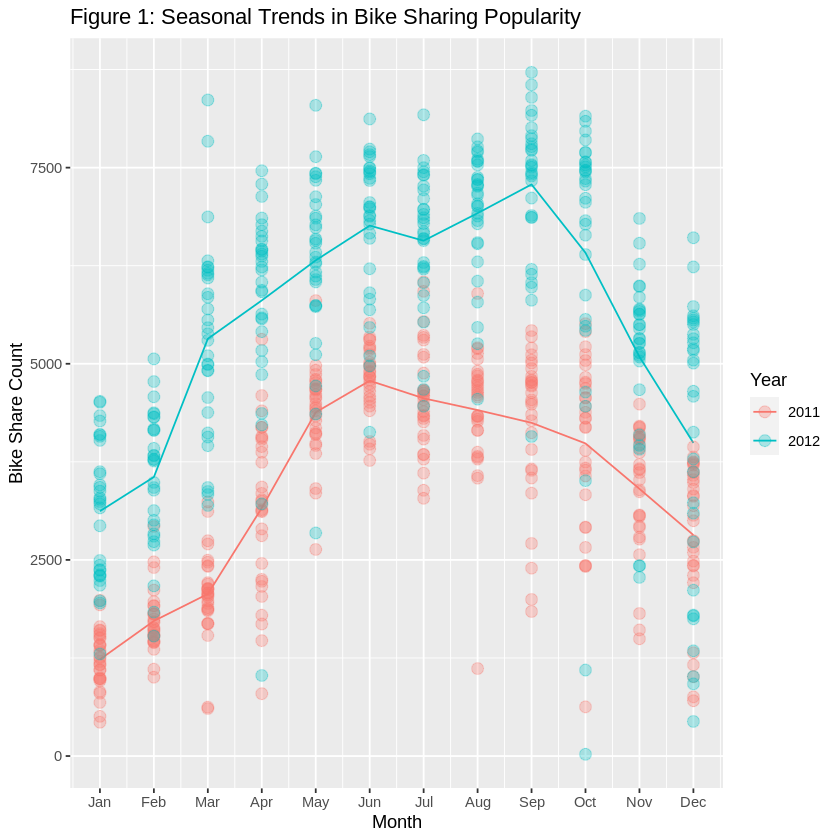

In [16]:
bike_data_plot_1 <- bike_data_denormalized |>
    group_by(mnth, yr) |>
    summarize(cnt = mean(cnt)) |>
    ggplot(aes(x = mnth, y = cnt, color = yr)) +
    geom_line() +
    geom_point(aes(x = mnth, y = cnt, color = yr), data = data, alpha = 0.3, size = 3) +
    labs(x = "Month", y = "Bike Share Count", color = "Year") +
    ggtitle("Figure 1: Seasonal Trends in Bike Sharing Popularity") +
    scale_x_continuous(breaks=seq(1,12,1), labels= month.abb)

bike_data_plot_1

This plot provides useful information regarding the best methods to use to predict out response variable. We can see from this chart the the response variable is highly cyclical, and thus we must keep in mind that any trends we see will likely not be linear when using `mnth` as an input variable. We can also see that there is a distinct difference between the number of users in 2011 and in 2012. This indicates that the userbase is growing, and if the number of users further in the future (say, 2013) were to be predicted, we would need to take this userbase growth into account. The difference between 2011 and 2012 also indicates that there will likely be a large difference between in-sample predictions (predicting the past), and out-of-sample predictions (predicting the future). Without recognizing the cyclic monthly trends or yearly userbase growth, we could have made testing mistakes that would have drastically overestimated our model's capabilities in the real world.

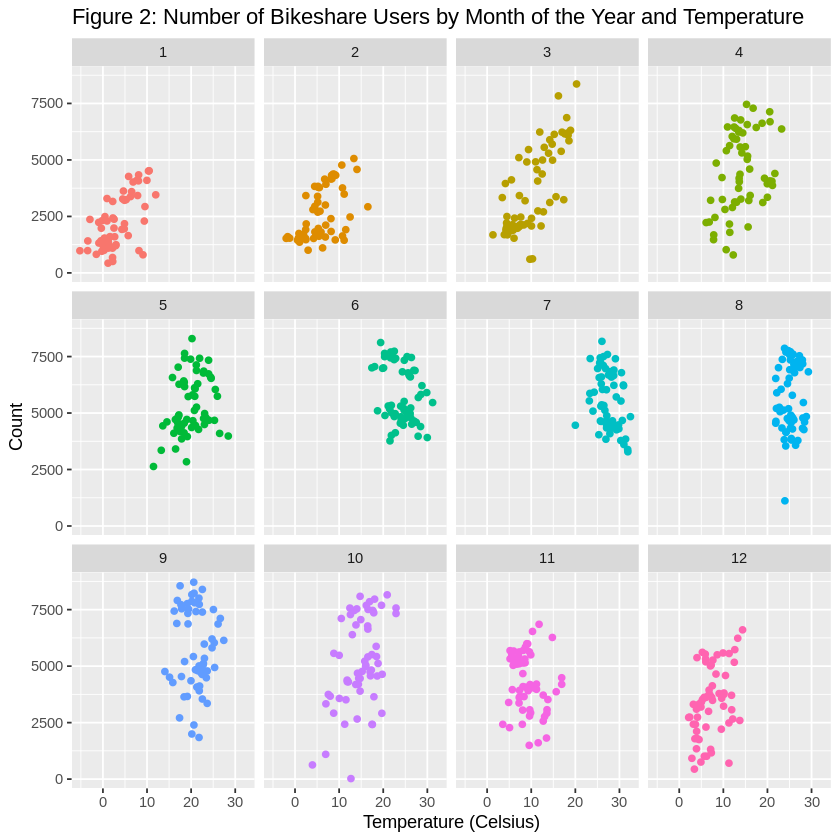

In [17]:
bike_data_plot_2 <- bike_data_denormalized %>% 
    ggplot(aes(x = temp, y = cnt, color = factor(mnth))) +
    geom_point() +
    facet_wrap(facets = vars(mnth)) +
    labs(title = "Figure 2: Number of Bikeshare Users by Month of the Year and Temperature",
        x = "Temperature (Celsius)",
        y = "Count",
        color = "Year") +
    theme(legend.position = "none")

bike_data_plot_2

This visualization provides more insight the cyclic monthly trend of the data. Based on this visualization, there is a clear relationship between the temperature and the number of users. As the temperature increases, the number of users increases. However, this trend also follows the seasons of the Northern Hemisphere, where the temperature (and number of users) is higher in the summer and lower in the winter. Since the month of the year is closely related to the temperature, the month of the year may be confounder in the proposed regression model, and will need to be analyzed with caution when we examine how LASSO changes the coefficients and interpret the results of our model.

### Methods/Plan

In order to make accurate predictions of future bike share usage, we will be performing Pinear regression and LASSO regularization to do feature selection, as LASSO is an effective tool to do Poisson regression, as seen in Hoissan and Ahmed, 2012 [2]. This should improve test accuracy by removing the chance of overfitting on weather variables that do not affect bike share usage. We will use cross-validation to choose the regularization factor. Additionally, we will attempt to encode the date as a numerical quantity rather than a series of month/year categorical variables. This will hopefully reduce the complexity of the model and prevent overfitting from damaging future predicitons. However, in order to account for the cyclical effects of time, we will do a basis expansion on the day of year by including a new variable cos(365/2π * dayOfYear + t) where t is the cycle offset chosen by cross-validation. This will appropriately model the trend between time and bike share count, while dramatically reducing the number of parameters in our model (which would otherwise be one for every month/year combination, plus any interaction terms).

This method assumes that the cycle is perfectly sinusoidal, however, it might be possible to alleviate this assumption in future experiments by including additional basis. This method also assumes that weather and time of year are independent when there is likely a moderate casual factor between them.

A major potential weakness we will have to look out for is potential non-linear trends between explanatory variables and our response. We somewhat took care of this problem with the time/response trend, but non-linearity could exist elsewhere too--especially with the weather-related explanatory variables. This could be a problem as our model would not be able to accurately follow these trends. For example, people might choose to avoid riding bikes when it's too cold, and when it's too hot. With this method, we would not accurately model this behavior. If we notice this harms our prediction accuracy, we could potentially fix this problem by adding basis expanions for the non-temporal explanatory variables as well. This would increase the complexiy of our model, but would likely be worth it if it improves prediction accuracy.

Additionally, this method could easily fail if our cross-validation is not performed carefully. If unreasonable values are tested and chosen for our regularization constant or cycle period, our model predictions accuracy could be seriously damaged as many variables could be erroniously selected or deselected, or our modeled cycle frequency could be misaligned with reality. We must be careful when performing cross-validation to ensure a reasonable range of values are tested.

### Model Implementation

In [18]:
# Replace `year`/`month` variables with `daysElapsed`
new_data <- data |> mutate(
    daysElapsed = as.numeric(difftime(dteday, '2011-01-01', units="days"))) |>
    select(-instant, -dteday, -yr, -mnth)

# Training/Testing split where test data is the "future"
future_training_data <- new_data |> 
    filter(daysElapsed < quantile(new_data$daysElapsed, 0.8))
future_testing_data <- new_data |>
    filter(daysElapsed >= quantile(new_data$daysElapsed, 0.8))

head(future_training_data)
nrow(future_training_data)
nrow(future_testing_data)

season,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,daysElapsed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,6,0,2,0.344167,0.805833,0.1604460,985,0
1,0,0,0,2,0.363478,0.696087,0.2485390,801,1
1,0,1,1,1,0.196364,0.437273,0.2483090,1349,2
1,0,2,1,1,0.200000,0.590435,0.1602960,1562,3
1,0,3,1,1,0.226957,0.436957,0.1869000,1600,4
1,0,4,1,1,0.204348,0.518261,0.0895652,1606,5


[1] 584

[1] 147

In [19]:
set.seed(1234)

# Function to create the new feature column based off of selected offset
createData <- function(data, dayOffset) {
    data |> mutate(
        cosDaysElapsed = cos(2*pi* (daysElapsed - dayOffset) / 365))
}

# Function to fit a lasso model given an offset to use
createModel <- function(data, dayOffset) {
    expanded_data <- createData(data, dayOffset)
    # expanded_data |> scale()
    model <- cv.glmnet(
        x = expanded_data |> select(-cnt) |> scale() |> as.matrix(),
        y = expanded_data |> select(cnt) |> as.matrix(),
        )
    model
}

In [20]:
# Offsets to try during cross validation
offsetsToTry <- seq(-182, 183, 10)

# For each offset, calculate best possible validation error
offsetScores <- map(
    .x = offsetsToTry, 
    .f = ~ {
        model <- createModel(future_training_data, .x)
        model$cvm[s = model$lambda.min]
        })

# Choose best offset and model from scores
bestOffset <- offsetsToTry[which.min(offsetScores)]
bestModel <- createModel(future_training_data, bestOffset)

In [21]:
bestOffset

[1] -2

11 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept)    4153.59932
season            .      
holiday           .      
weekday           .      
workingday        .      
weathersit     -260.35253
temp            254.61788
hum               .      
windspeed       -49.06222
daysElapsed     863.52464
cosDaysElapsed -625.44589


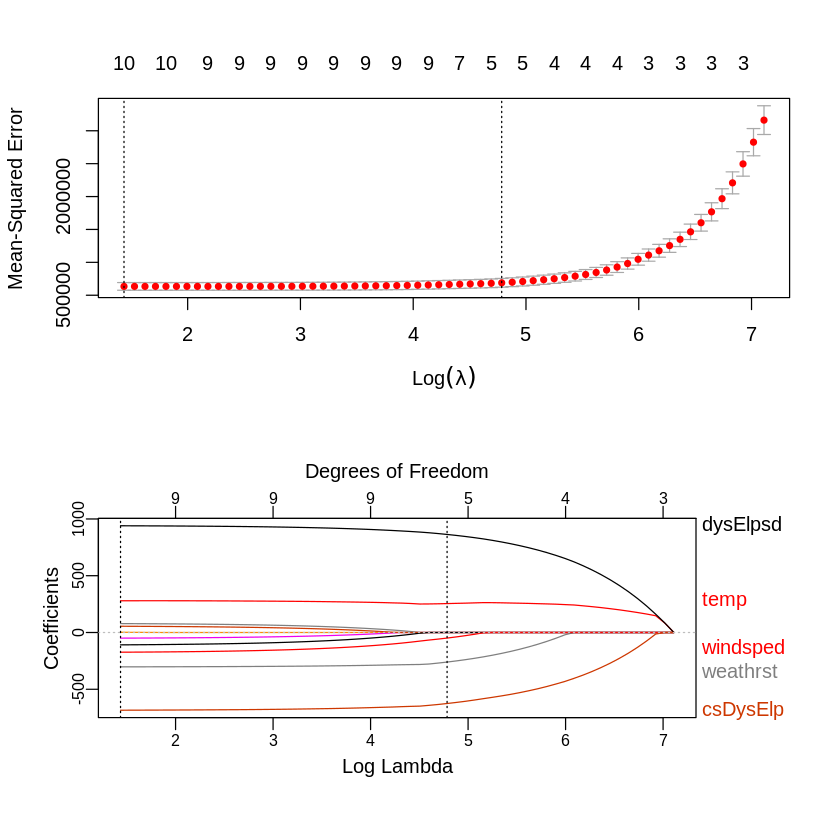

In [22]:
# layout(matrix(c(1,1,2,3), nrow = 2, ncol = 2, byrow = TRUE))
par(mfrow=c(2,1))

plot(bestModel)

plot_glmnet(bestModel$glmnet.fit, "lambda", label = 5)
abline(v = log(bestModel$lambda.min), lty='dotted')
abline(v = log(bestModel$lambda.1se), lty='dotted')

print(coef(bestModel))
# plot(offsetsToTry, offsetScores, type='l')

# Lasso model output

Performing LASSO selection tells us that we achive the best validation scores when using only the coefficients `Days Elapsed`, `Temperature`, `Wind Speed`, `Weather` and `cos(Days Elapsed)`.

### Results

Warning message in training_predictions - future_training_data$cnt:
“longer object length is not a multiple of shorter object length”
Warning message in testing_predictions - future_testing_data$cnt:
“longer object length is not a multiple of shorter object length”


Mean Training Error,Mean Testing Error
<dbl>,<dbl>
1104,2491


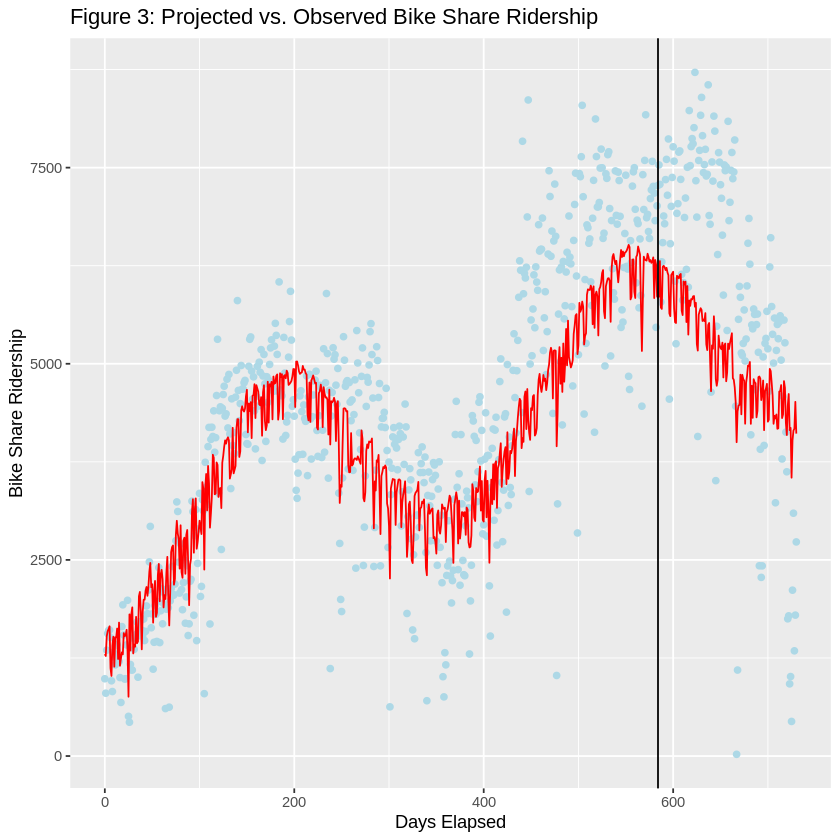

In [28]:
all_predictions <- predict(
    bestModel, 
    createData(new_data, bestOffset) |> 
        select(-cnt) |> 
        scale() |>
        as.matrix())
training_predictions <- predict(
    bestModel, 
    createData(new_data, bestOffset) |> 
        select(-cnt) |> 
        scale() |>
        as.matrix())
testing_predictions <- predict(
    bestModel, 
    createData(new_data, bestOffset) |> 
        select(-cnt) |> 
        scale() |>
        as.matrix())

errors <- tibble(
    `Mean Training Error` = 
        mean(abs(training_predictions - future_training_data$cnt)), 
    `Mean Testing Error` = 
        mean(abs(testing_predictions - future_testing_data$cnt))) |>
    round()
errors

predictions <- new_data |> mutate(predictions = all_predictions)
predictions |>
    ggplot(aes(x = daysElapsed, y = cnt)) +
    geom_point(color="lightblue") +
    geom_line(aes(x = daysElapsed, y = predictions), color="red") +
    labs(x = "Days Elapsed", y = "Bike Share Ridership") +
    ggtitle("Figure 3: Projected vs. Observed Bike Share Ridership") +
    geom_vline(aes(xintercept= quantile(new_data$daysElapsed, 0.8)))

### Discussion

The results seen in Figure 3 (above) are promising. Despite the increase in variance of our response as time increases, we managed to predict ridership with remarkable accuracy using just time and weather information. Our mean testing error is 2500, which is approximately +/- 40% on our testing set. This accuracy is about what we expected, and while it is not perfect, it allows us to make predictions about the general amount of users on any given day in the future. This level of accuracy would be useful for a bikesharing company, which could use this model to know when they need to increase the number of bikes available, or when lower bike use is expected and bikes could be taken in for maintenance. 

The two largest limitation of the model is the possibility of confounders. As shown in the exploratory visualizations, the number of bikeshare users changes with both the temperature and the month, and it is common knowledge that the temperature also changes with the month, possibly creating a confounder. We also know that season and month are very highly correlated, which could cause multicollinearity problems with our analysis and could artificially increase the accuracy of the model [3]. Hopefully, LASSO would have mitigated some of these problems by modifying the coefficients and selecting variables, but it is difficult to tell how much LASSO has helped. 

As well, this model assumes that the variance is approximately the same as the mean. This assumption may not be true, which could compromise the accuracy of the results. Additional analysis could have been done to analyze whether our dataset upheld all of the assumptions that come with Poisson regression, but space limitations prevented us from doing this. 

With more space, we would also have liked to run an analysis of the VIF to exclude multicollinear variables, and possibly compare LASSO shrinkage and selection to Ridge shrinkage, which could have given us some insight into the presence of multicollinear and confounding variables, and whether the two methods choose to emphasize the same variables.

Despite these limitations, our question has been answered, and we have found that we *can* rely on this model going forward to make good estimates about bike usage based on future weather trends!

### Sources:

Dataset used: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

[1]. "A review on bike-sharing: The factors affecting bike-sharing demand" by Ezgi Eren and Volkan Emre U: https://www.sciencedirect.com/science/article/pii/S2210670719312387

[2]. "Shrinkage and Penalty Estimators of a Poisson Regression Model" by Shakawat Hoissan and Ejaz Ahmed: https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1467-842X.2012.00679.x

[3]. https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/